In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from tqdm import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-esk6rfcf because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
d_val = np.loadtxt(open("deepsea_embedding.val.csv", "rb"), delimiter=",")

In [3]:
d_train = np.loadtxt(open("deepsea_embedding.csv", "rb"), delimiter=",")

In [4]:
data_dir = "/mnt/ceph/users/zzhang/workspace_src/AMBER/examples/data/zero_shot_deepsea"
with h5py.File(os.path.join(data_dir, "train.h5"), 'r') as store:
    y_train = store['y'][()]

In [5]:
print(d_train.shape)
print(y_train.shape)

(4400000, 768)
(4400000, 919)


In [6]:
ss.spearmanr(d_train[:,0], d_train[:,1])

SpearmanrResult(correlation=-0.2992470642598229, pvalue=0.0)

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#d_train_t = np.transpose(d_train)
pca = PCA(n_components=10, random_state=777)
# scale each gene to Z-score
scaled_df = scale(d_train, axis=1)
pca.fit(scaled_df)


PCA(n_components=10, random_state=777)

In [8]:
# total variance explained
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_[:5])

[0.24027997 0.17025756 0.08607878 0.07270096 0.04507931 0.04000471
 0.03196324 0.02339626 0.01889562 0.01523598]


0.6143965769391342

In [9]:
# read in 919 task annotations
task_annot = pd.read_table("/mnt/ceph/users/zzhang/DeepSEA/deepsea-keras/resources/label_names.renamed.txt", header=None,
                          sep="|")
task_annot.rename(columns={0:'cell', 1:'factor', 2:'cond'}, inplace=True)
task_annot

,cell,factor,cond
0,8988T,DNase,None
1,AoSMC,DNase,None
2,Chorion,DNase,None
3,CLL,DNase,None
4,Fibrobl,DNase,None
...,...,...,...
914,Osteoblasts,H3K4me1,None
915,Osteoblasts,H3K4me2,None
916,Osteoblasts,H3K4me3,None
917,Osteoblasts,H3K79me2,None


In [10]:
print(task_annot.query('factor=="DNase" and cell=="K562"').head(3))
print(task_annot.query('factor=="YY1" and cell=="K562"').head(3))
print(task_annot.query('factor=="H3K4me3" and cell=="K562"').head(3))
print(task_annot.query('factor=="Pol2" and cell=="K562"').head(3))

    cell factor  cond
61  K562  DNase  None
     cell factor  cond
369  K562    YY1  None
370  K562    YY1  None
676  K562    YY1  None
     cell   factor  cond
848  K562  H3K4me3  None
     cell factor    cond
354  K562   Pol2    None
645  K562   Pol2  IFNa30
646  K562   Pol2  IFNa6h


In [11]:
pcs_p = ['bert_pc%i_p'%i for i in range(1,11)]
pcs_n = ['bert_pc%i_n'%i for i in range(1,11)]
task_annot[pcs_p] = 0
task_annot[pcs_n] = 0

if os.path.isfile("deepsea.tasks.csv"):
    for i in tqdm(range(task_annot.shape[0])):
        pc1_p = pca.transform(d_train[y_train[:,i]==1])
        pc1_n = pca.transform(d_train[y_train[:,i]==0])
        task_annot.at[i, pcs_p] = pc1_p.mean(axis=0)
        task_annot.at[i, pcs_n] = pc1_n.mean(axis=0)
        task_annot.to_csv("deepsea_embedding.tasks.csv", index=False)
else:
    task_annot = pd.read_csv("deepsea_embedding.tasks.csv")

100%|██████████| 919/919 [6:42:48<00:00, 26.30s/it]  


In [25]:
# DNase - K562
i = 61
print(task_annot.iloc[i, 0:3])
pc1_p = task_annot.loc[i, pcs_p]
pc1_n = task_annot.loc[i, pcs_n]
print("pos", ["%.3f"%x for x in pc1_p])
print("neg", ["%.3f"%x for x in pc1_n])
print("diff", ["%.3f"%x for x in pc1_p.to_numpy() - pc1_n.to_numpy()])
print("logfc", ["%.3f"%np.log(x) for x in pc1_p.to_numpy()/pc1_n.to_numpy()])

cell       K562
factor    DNase
cond       None
Name: 61, dtype: object
pos ['2.636', '4.584', '1.374', '3.525', '7.325', '1.307', '5.153', '0.312', '1.006', '-0.176']
neg ['1.801', '4.891', '1.277', '3.250', '7.346', '1.297', '5.243', '0.392', '0.952', '-0.133']
diff ['0.835', '-0.307', '0.097', '0.276', '-0.021', '0.010', '-0.090', '-0.081', '0.054', '-0.043']
logfc ['0.381', '-0.065', '0.073', '0.081', '-0.003', '0.007', '-0.017', '-0.230', '0.056', '0.282']


In [22]:
# YY1 - K562
i = 676
print(task_annot.iloc[i, 0:3])
pc1_p = task_annot.loc[i, pcs_p]
pc1_n = task_annot.loc[i, pcs_n]
print("pos", ["%.3f"%x for x in pc1_p])
print("neg", ["%.3f"%x for x in pc1_n])
print("diff", ["%.3f"%x for x in pc1_p.to_numpy() - pc1_n.to_numpy()])
print("logfc", ["%.3f"%np.log(x) for x in pc1_p.to_numpy()/pc1_n.to_numpy()])

cell      K562
factor     YY1
cond      None
Name: 676, dtype: object
pos ['3.784', '4.410', '1.714', '4.524', '7.380', '1.347', '5.087', '0.115', '1.127', '-0.224']
neg ['1.839', '4.876', '1.281', '3.260', '7.344', '1.298', '5.238', '0.389', '0.954', '-0.135']
diff ['1.945', '-0.466', '0.433', '1.263', '0.035', '0.050', '-0.151', '-0.274', '0.173', '-0.089']
logfc ['0.722', '-0.100', '0.291', '0.327', '0.005', '0.038', '-0.029', '-1.221', '0.167', '0.508']


In [23]:
# H3K4me3 - K562
i = 848
print(task_annot.iloc[i, 0:3])
pc1_p = task_annot.loc[i, pcs_p]
pc1_n = task_annot.loc[i, pcs_n]
print("pos", ["%.3f"%x for x in pc1_p])
print("neg", ["%.3f"%x for x in pc1_n])
print("diff", ["%.3f"%x for x in pc1_p.to_numpy() - pc1_n.to_numpy()])
print("logfc", ["%.3f"%np.log(x) for x in pc1_p.to_numpy()/pc1_n.to_numpy()])

cell         K562
factor    H3K4me3
cond         None
Name: 848, dtype: object
pos ['2.818', '4.595', '1.491', '3.885', '7.322', '1.318', '5.089', '0.277', '1.053', '-0.196']
neg ['1.759', '4.899', '1.263', '3.210', '7.346', '1.296', '5.251', '0.398', '0.946', '-0.130']
diff ['1.059', '-0.305', '0.227', '0.675', '-0.025', '0.022', '-0.162', '-0.121', '0.107', '-0.066']
logfc ['0.471', '-0.064', '0.166', '0.191', '-0.003', '0.017', '-0.031', '-0.363', '0.107', '0.409']


In [24]:
# Pol2 - K562
i = 354
print(task_annot.iloc[i, 0:3])
pc1_p = task_annot.loc[i, pcs_p]
pc1_n = task_annot.loc[i, pcs_n]
print("pos", ["%.3f"%x for x in pc1_p])
print("neg", ["%.3f"%x for x in pc1_n])
print("diff", ["%.3f"%x for x in pc1_p.to_numpy() - pc1_n.to_numpy()])
print("logfc", ["%.3f"%np.log(x) for x in pc1_p.to_numpy()/pc1_n.to_numpy()])

cell      K562
factor    Pol2
cond      None
Name: 354, dtype: object
pos ['3.695', '4.465', '1.621', '4.255', '7.325', '1.328', '5.057', '0.194', '1.121', '-0.239']
neg ['1.794', '4.886', '1.273', '3.237', '7.345', '1.297', '5.243', '0.394', '0.950', '-0.132']
diff ['1.901', '-0.421', '0.348', '1.018', '-0.020', '0.031', '-0.186', '-0.199', '0.171', '-0.107']
logfc ['0.723', '-0.090', '0.242', '0.273', '-0.003', '0.024', '-0.036', '-0.706', '0.166', '0.591']


# use logFC and plot all features

In [54]:
dataroot = "/mnt/home/zzhang/ceph/amber_github/AMBER/examples/AMBIENT/real_deepsea"
meta = pd.read_table(dataroot + "/data/zero_shot/full_metadata.tsv")
meta = meta.loc[meta['molecule']=='DNA']
indexer = pd.read_table(dataroot + "/data/zero_shot_deepsea/label_index_with_category_annot.tsv")
indexer['labels'] = ["_".join(x.split("--")).replace("\xa0","") for x in indexer['labels']]
from collections import Counter
counter = Counter()
new_label = []
for label in indexer['labels']:
    if counter[label] > 0:
        new_label.append("%s_%i"%(label, counter[label]))
    else:
        new_label.append(label)
    counter[label] += 1
indexer.index = new_label
meta['new_name'] = [x.replace("+", "_") for x in meta['new_name']]
meta['col_idx'] = [indexer.loc[x, "index"] if x in indexer.index else np.nan for x in meta['new_name']]
meta = meta.dropna()
meta['col_idx'] = meta['col_idx'].astype('int')
meta.index = meta['feat_name']

In [74]:
task_annot.iloc[0]

cell              8988T
factor            DNase
cond               None
bert_pc1_p      3.19753
bert_pc2_p      4.45538
bert_pc3_p      1.37891
bert_pc4_p      3.54934
bert_pc5_p      7.32302
bert_pc6_p      1.30444
bert_pc7_p      5.07957
bert_pc8_p     0.335971
bert_pc9_p      1.00287
bert_pc10_p   -0.168483
bert_pc1_n      1.78899
bert_pc2_n      4.89208
bert_pc3_n      1.27774
bert_pc4_n       3.2523
bert_pc5_n      7.34533
bert_pc6_n      1.29738
bert_pc7_n       5.2444
bert_pc8_n     0.390415
bert_pc9_n     0.952431
bert_pc10_n   -0.133882
Name: 0, dtype: object

In [75]:
print(pcs_p, pcs_n)

['bert_pc1_p', 'bert_pc2_p', 'bert_pc3_p', 'bert_pc4_p', 'bert_pc5_p', 'bert_pc6_p', 'bert_pc7_p', 'bert_pc8_p', 'bert_pc9_p', 'bert_pc10_p'] ['bert_pc1_n', 'bert_pc2_n', 'bert_pc3_n', 'bert_pc4_n', 'bert_pc5_n', 'bert_pc6_n', 'bert_pc7_n', 'bert_pc8_n', 'bert_pc9_n', 'bert_pc10_n']


In [76]:
pcs = ["pc%i"%i for i in range(1,11)]
for feat in meta.feat_name:
    pc1_p = task_annot.loc[meta.loc[feat, 'col_idx'], pcs_p]
    pc1_n = task_annot.loc[meta.loc[feat, 'col_idx'], pcs_n]
    meta.at[feat, pcs] = np.log(pc1_p.to_numpy(dtype='float') / pc1_n.to_numpy(dtype='float'))

In [77]:
meta.iloc[0]

index                                                                54
feat_name                                                        FEAT54
molecule                                                            DNA
genome                                                             hg19
assay_target_class                                              Histone
assay_target                                                    H2AK5ac
biosample_type                                                  H1-hESC
treatment                                                          None
peak_count                                                       102315
orig_filename         /data/home/ecofer/git/regulatory_sequencing_su...
orig_name                                          H1-hESC|H2AK5ac|None
new_name                                           H1-hESC_H2AK5ac_None
new_filename          /data/home/ecofer/git/regulatory_sequencing_su...
col_idx                                                         

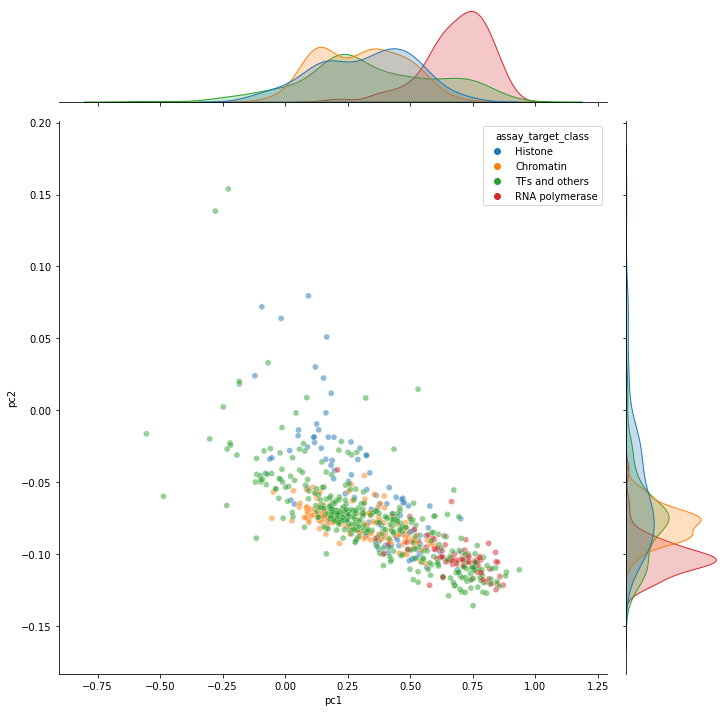

In [84]:
sns.jointplot(x='pc1', y='pc2', hue='assay_target_class', alpha=0.5, data=meta, ax=ax, height=10,
             marginal_kws={'common_norm':False})

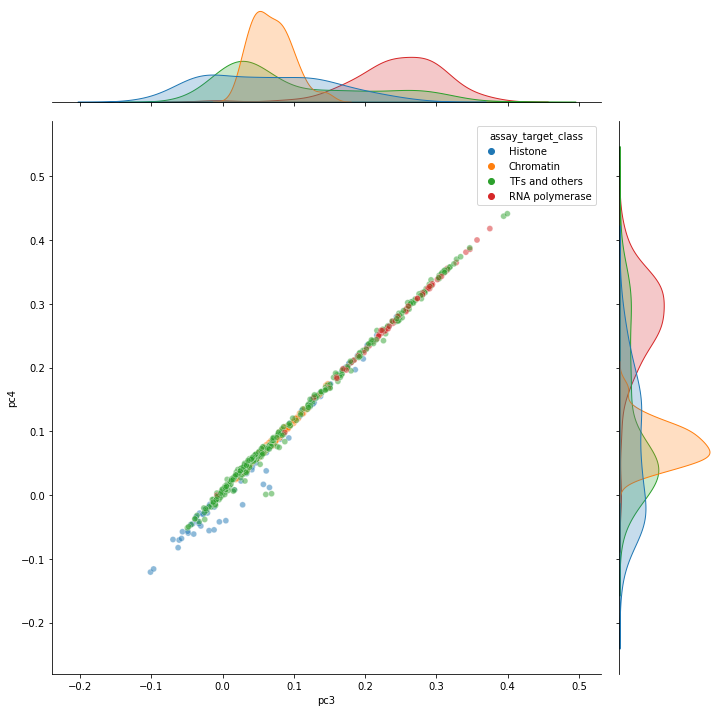

In [85]:
sns.jointplot(x='pc3', y='pc4', hue='assay_target_class', alpha=0.5, data=meta, ax=ax, height=10,
             marginal_kws={'common_norm':False})

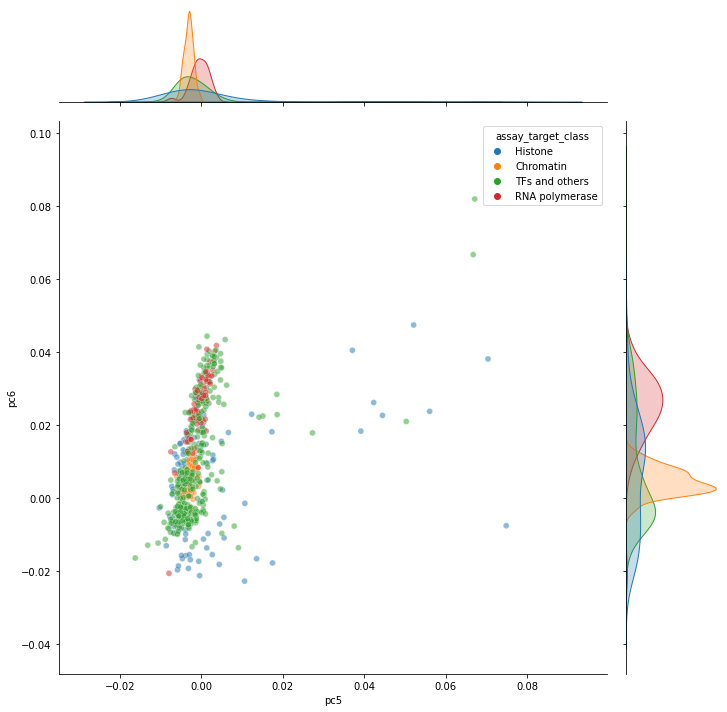

In [86]:
sns.jointplot(x='pc5', y='pc6', hue='assay_target_class', alpha=0.5, data=meta, ax=ax, height=10,
             marginal_kws={'common_norm':False})

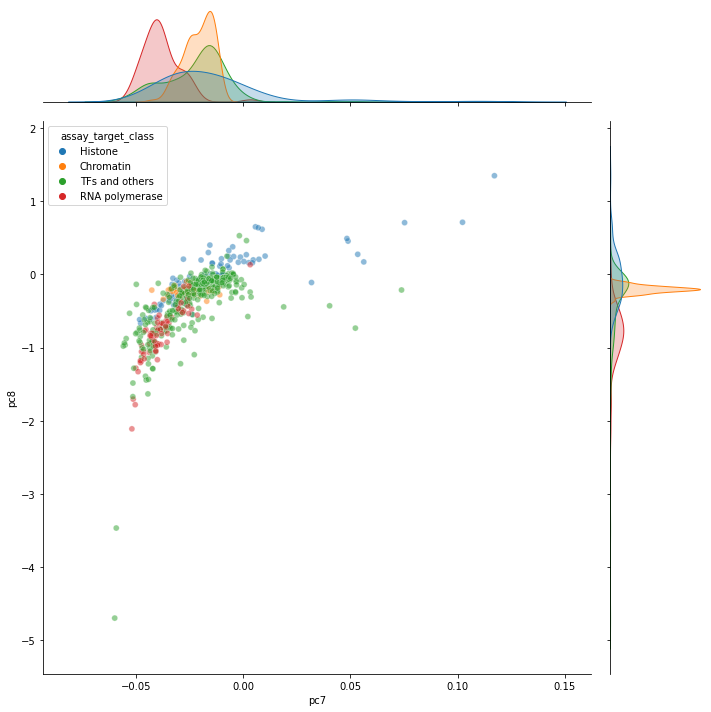

In [87]:
sns.jointplot(x='pc7', y='pc8', hue='assay_target_class', alpha=0.5, data=meta, ax=ax, height=10,
             marginal_kws={'common_norm':False})

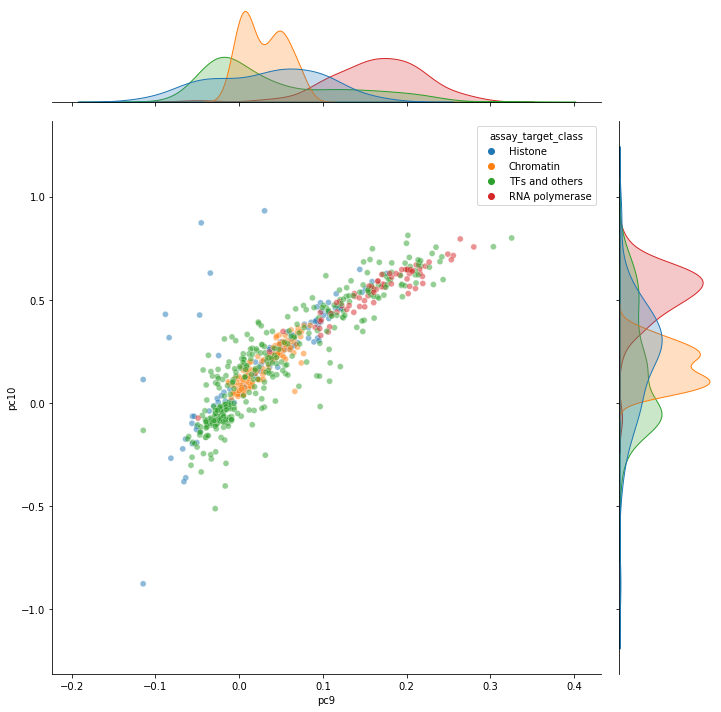

In [88]:
sns.jointplot(x='pc9', y='pc10', hue='assay_target_class', alpha=0.5, data=meta, ax=ax, height=10,
             marginal_kws={'common_norm':False})